In [2]:
import pandas as pd
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from funcs_support import area_mean
from var_partitioning.stats import calculate_impact_test, variability_partitioning

import numpy as np

np.seterr(divide='ignore', invalid='ignore')

import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning)

warnings.filterwarnings(
    'ignore',
    message='invalid value encountered in divide'
)


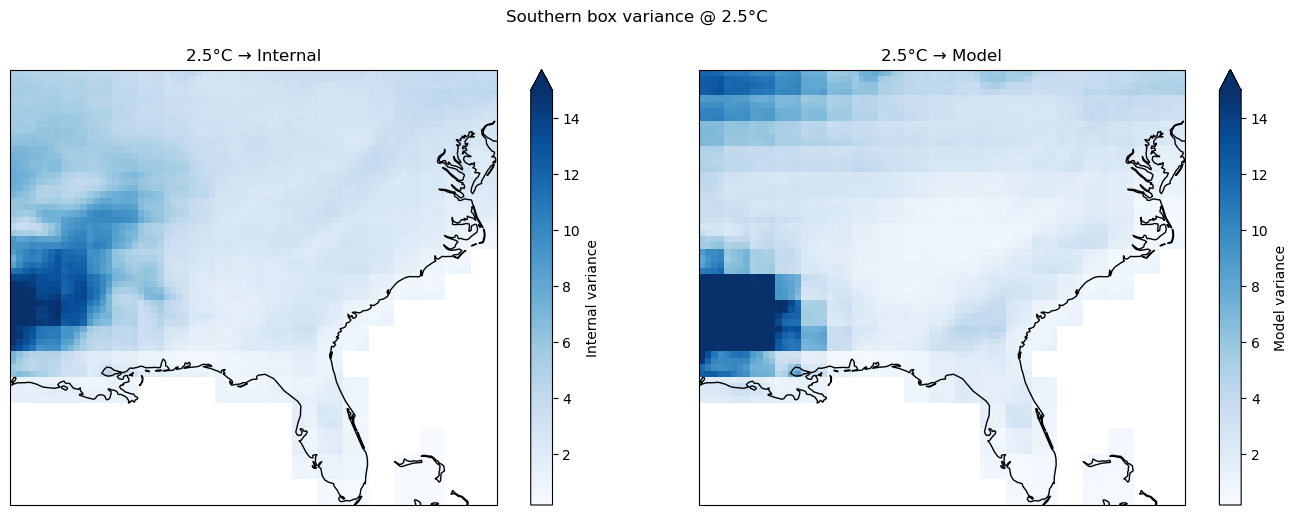

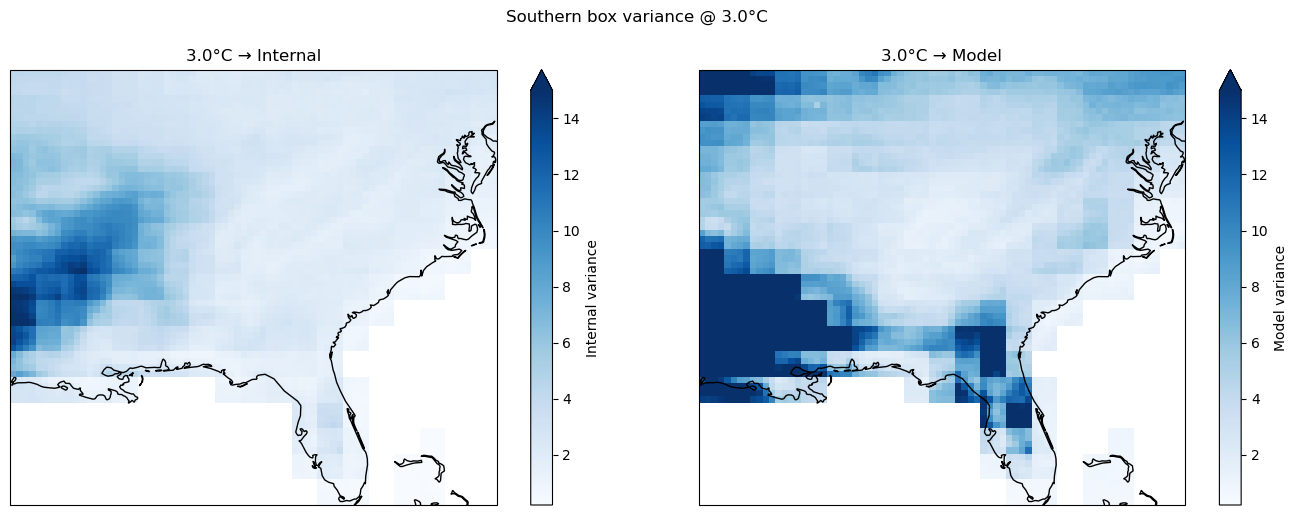

In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from dask import compute

from var_partitioning.stats import calculate_impact_test, variability_partitioning

# 1) Your Southern box
lon_min, lon_max = -94, -75
lat_min, lat_max =   25,  42

def plot_southern_variances(gwl):
    # a) Get the full-grid mortality impacts
    mort_all, _ = calculate_impact_test(gwl)
    
    # b) Slice to the South *before* partitioning
    mort_south = mort_all.sel(
        lon=slice(lon_min, lon_max),
        lat=slice(lat_min, lat_max)
    ).compute()
    
    # c) Partition *only* that subset
    stats = variability_partitioning(mort_south)
    iv = stats['internal_variance']
    mv = stats['model_unc']
    
    # e) Compute vmin/vmax on the small in-memory arrays
    vmin = min(iv.min(), mv.min())
    vmax = 15 
    
    # f) Plot side-by-side with shared scale
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(14,5),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    
    iv.plot(
        ax=ax1, cmap='Blues',
        vmin=vmin, vmax=vmax,
        cbar_kwargs={'label': 'Internal variance'}
    )
    ax1.coastlines()
    ax1.set_title(f"{gwl}°C → Internal")
    
    mv.plot(
        ax=ax2, cmap='Blues',
        vmin=vmin, vmax=vmax,
        cbar_kwargs={'label': 'Model variance'}
    )
    ax2.coastlines()
    ax2.set_title(f"{gwl}°C → Model")
    
    plt.suptitle(f"Southern box variance @ {gwl}°C", y=1.02)
    plt.tight_layout()
    plt.show()

# 2) Run for your GWLs
for gwl in (2.5, 3.0):
    plot_southern_variances(gwl)


GWL = 2.5°C → Southern mean fractions:
   Internal: 0.54,  Model: 0.46


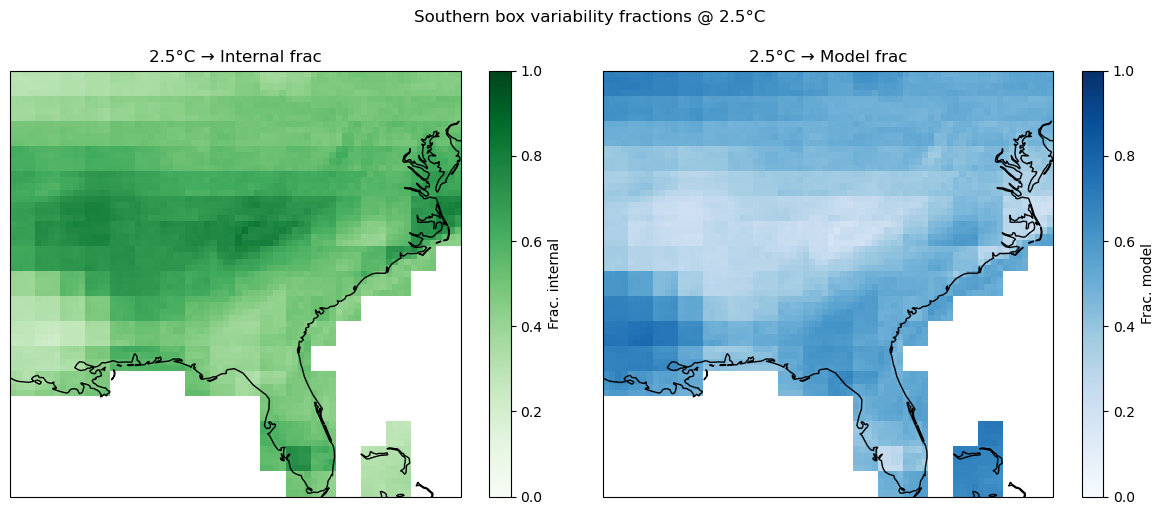

GWL = 3.0°C → Southern mean fractions:
   Internal: 0.37,  Model: 0.63


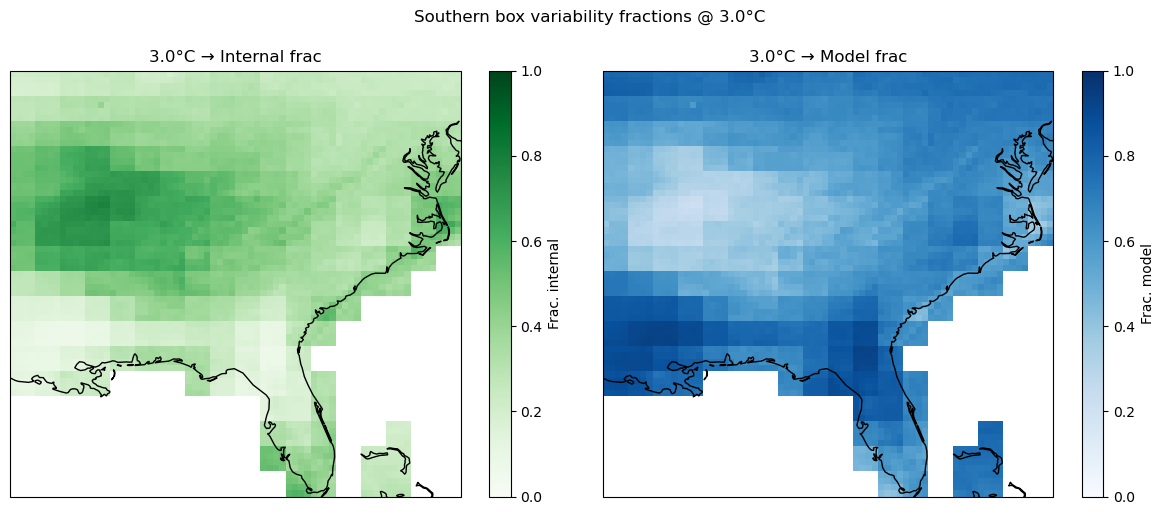

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from var_partitioning.stats import calculate_impact_test, variability_partitioning

# 1) Southern box bounds
lon_min, lon_max = -94, -75
lat_min, lat_max =   25,  42

for gwl in (2.5, 3.0):
    # 2) get full‐grid mortality (lazy), slice & compute just the box
    mort_all, _   = calculate_impact_test(gwl)
    mort_south    = (
        mort_all
        .sel(lon=slice(lon_min, lon_max),
             lat=slice(lat_min, lat_max))
        .compute()             # loads only the southern pixels
    )
    
    # 3) partition on that small slice
    stats         = variability_partitioning(mort_south)
    iv            = stats["internal_variance"]
    mv            = stats["model_unc"]
    
    # 4) build fractional DataArrays
    frac_int      = iv / (iv + mv)
    frac_mod      = mv / (iv + mv)
    
    # 5) get region‐mean fractions
    mean_int_frac = float(frac_int.mean().item())
    mean_mod_frac = float(frac_mod.mean().item())
    print(f"GWL = {gwl}°C → Southern mean fractions:")
    print(f"   Internal: {mean_int_frac:.2f},  Model: {mean_mod_frac:.2f}")
    
    # 6) (optional) quick side‐by‐side map of the fractions
    vmin, vmax = 0, 1
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(12, 5),
        subplot_kw={"projection": ccrs.PlateCarree()}
    )
    frac_int.plot(
        ax=ax1, cmap="Greens", vmin=vmin, vmax=vmax,
        cbar_kwargs={"label": "Frac. internal"}
    )
    ax1.coastlines(); ax1.set_title(f"{gwl}°C → Internal frac")
    
    frac_mod.plot(
        ax=ax2, cmap="Blues", vmin=vmin, vmax=vmax,
        cbar_kwargs={"label": "Frac. model"}
    )
    ax2.coastlines(); ax2.set_title(f"{gwl}°C → Model frac")
    
    plt.suptitle(f"Southern box variability fractions @ {gwl}°C", y=1.02)
    plt.tight_layout()
    plt.show()
